In [1]:
import urllib.request
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = urllib.request.urlopen('https://raw.githubusercontent.com/karpathy/makemore/master/names.txt').read().decode('utf-8').splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# make dataset
block_size = 3
def build_dataset(words):
  X, Y = [], []

  for word in words:
    context = [0] * block_size
    word += '.'
    for ch in word:
      X.append(context)
      idx = stoi[ch]
      Y.append(idx)
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
train_words = words[:n1]
dev_words = words[n1:n2]
test_words = words[n2:]
Xtrain, Ytrain  = build_dataset(train_words)
Xdev,   Ydev    = build_dataset(dev_words)
Xtest,  Ytest   = build_dataset(test_words)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [28]:
n_emb = 10
n_hidden1 = 100
n_hidden2 = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb,                generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden1),   generator=g) * (5/3)/((n_emb * block_size)**0.5)
# this is useless bcz of batch norm, see urself why.
#b1 = torch.randn((n_hidden1,),                      generator=g) * 0.1
W2 = torch.randn((n_hidden1, n_hidden2),            generator=g) * (5/3)/(n_hidden1**0.5) # these multiplication for 1st step to make loss not very large
# this is useless bcz of batch norm, see urself why.
#b2 = torch.randn((n_hidden2),                       generator=g) * 0.0
W3 = torch.randn((n_hidden2, vocab_size),           generator=g) * 0.01
b3 = torch.randn((vocab_size),                      generator=g) * 0.0

bngain1 = torch.ones((1, n_hidden1))
bnbias1 = torch.zeros((1, n_hidden1))

bngain2 = torch.ones((1, n_hidden2))
bnbias2 = torch.zeros((1, n_hidden2))

bn1mean_running = torch.zeros((1, n_hidden1))
bn1std_running = torch.ones((1, n_hidden1))
bn2mean_running = torch.zeros((1, n_hidden2))
bn2std_running = torch.ones((1, n_hidden2))

parameters = [C, W1, W2, W3, b3, bngain1, bnbias1, bngain2, bnbias2]

p_size = sum(p.nelement() for p in parameters)
print(f"{p_size=}")
for p in parameters:
  p.requires_grad = True # if multiplying by constant, use requires_grad separately after

p_size=29297


In [29]:
max_steps = 30000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
  #mini batch
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
  X_batch = Xtrain[ix]
  Y_batch = Ytrain[ix]
  ##forward
  emb = C[X_batch]
  emb = emb.reshape(emb.shape[0], -1)
  h1preact = emb @ W1 #+ b1

  bn1meani = h1preact.mean(0, keepdims=True)
  bn1stdi = h1preact.std(0, keepdims=True)
  with torch.no_grad():
    bn1mean_running = 0.999 * bn1mean_running + 0.001 * bn1meani
    bn1std_running = 0.999 * bn1std_running + 0.001 * bn1stdi
  h1preact = bngain1 * (h1preact - bn1meani)/bn1stdi  + bnbias1
  h1 = torch.tanh(h1preact)
  h2preact = h1 @ W2 #+ b2

  bn2meani = h2preact.mean(0, keepdims=True)
  bn2stdi = h2preact.std(0, keepdims=True)
  with torch.no_grad():
    bn2mean_running = 0.999 * bn2mean_running + 0.001 * bn2meani
    bn2std_running = 0.999 * bn2std_running + 0.001 * bn2stdi
  h2preact = bngain2 * (h2preact - bn2meani)/bn2stdi  + bnbias2
  h2 = torch.tanh(h2preact)
  logits = h2 @ W3 + b3
  loss = F.cross_entropy(logits, Y_batch)
  # backward
  for p in parameters:
    p.grad = None
  loss.backward()
  # grad descent
  #lr = 0.1 if i < max_steps*0.5 else 0.01
  #lr = (max_steps-i)/max_steps*0.1
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track
  lossi.append(loss.log10().item())
  stepi.append(i)

  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
print(loss.item())

      0/  30000: 3.3080
  10000/  30000: 2.1124
  20000/  30000: 2.1652
2.05940318107605


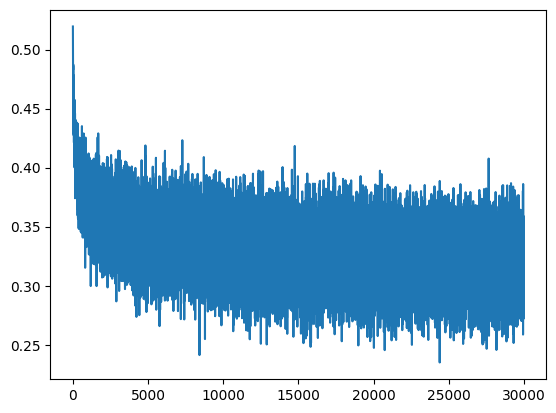

In [30]:
plt.plot(stepi, lossi)

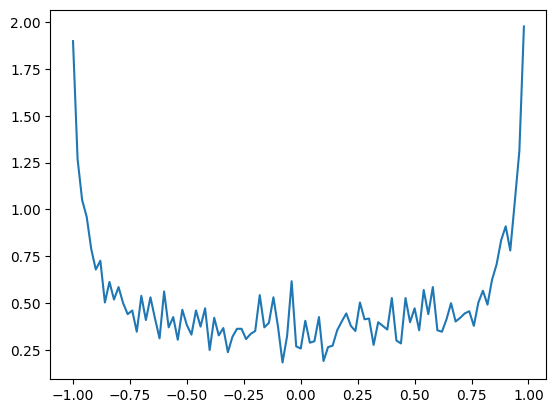

In [31]:
#plt.hist(h2.view(-1).tolist(), bins=50)
hy, hx = torch.histogram(h1.view(-1), density=True)
plt.plot(hx[:-1].detach(), hy.detach())

if so many h tanh outcomes are close to +/-1, related gradients will become 0, making them dead. remember derivative is (1-tanh^2(x)) * out.grad.

other activation functions -
* sigmoid - sigmoid is 1/(1 + e^-x). derivative is sig(1-sig)
* relu
* leaky relu

In [14]:
# these stats could be computed while trainng batch wise.
with torch.no_grad():
  emb = C[Xtest]
  emb = emb.reshape(emb.shape[0], -1)
  h1preact = emb @ W1 #+ b1
  bn1mean = h1preact.mean(0, keepdims=True)
  bn1std = h1preact.std(0, keepdims=True)
  h1preact = bngain1 * (h1preact - bn1mean)/bn1std  + bnbias1
  h1 = torch.tanh(h1preact)

  h2preact = h1 @ W2 #+ b2
  bn2mean = h2preact.mean(0, keepdims=True)
  bn2std = h2preact.std(0, keepdims=True)

In [15]:
@torch.no_grad() # forward pass this function as if require_grad=False, no tracking for optimization or computation of grad
def split_loss(split):
  X, Y = {
      'train' : (Xtrain, Ytrain),
      'dev'   : (Xdev,   Ydev),
      'test'  : (Xtest,  Ytest),
  }[split]
  emb = C[X]
  emb = emb.reshape(emb.shape[0], -1)
  h1preact = emb @ W1 #+ b1
  h1preact = bngain1 * (h1preact - bn1mean_running)/bn1std_running  + bnbias1
  h1 = torch.tanh(h1preact)
  h2preact = h1 @ W2 #+ b2
  h2preact = bngain2 * (h2preact - bn2mean_running)/bn2std_running  + bnbias2
  h2 = torch.tanh(h2preact)
  logits = h2 @ W3 + b3
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

split_loss('train')
split_loss('dev')

2.0736606121063232
2.118739128112793


* concepts learned so far - **weight initialization**. read here - https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

few things -
*   we want initial loss closer, so we want initial logits to be equal but not zero, (be careful dont put weight to be zero)
*   we dont want hidden layer weights to be s.t. outcome of tanh/sigmoid becomes close to 1, otherwise their gradients will become zero

lets **next** learn about **batch normalization**

> each hidden layer neuron's output (just before activation) can be normaized to be standard gaussian distribution, across the mini-batch. Also along with trainiable possibility of scale and shift - bngain & bnbias

* it has regulazier effect.
* it stabilizes training.
* it reduces trainign speed, as each neuron waits for all batches to reach here.
* batch normalization was 1st one.
* difficult to get rid of.
* other - layer, group, normalization etc

** what happens to the simngle example prediction? isnt single input's mean and std might be too varied from training?
> solution : compute these bn stats over all training data without affecting gradients --- **OR** --- these stats could be computed while trainng batch wise. - refere code

In [116]:
bngain1

tensor([[1.3526, 1.2347, 0.9944, 1.4224, 0.8954, 1.0223, 1.4015, 0.9338, 0.9632,
         1.2290, 1.0906, 1.1556, 1.2168, 1.2384, 1.2746, 1.3116, 1.5192, 1.5432,
         1.0984, 1.2969, 1.5843, 1.0710, 1.3536, 1.3803, 1.2390, 1.3098, 1.2053,
         1.0065, 1.2080, 1.4155, 1.2778, 1.4433, 1.3900, 1.2763, 1.2556, 1.1290,
         1.2213, 1.2336, 1.2384, 1.1838, 1.1872, 1.1690, 1.1086, 1.2378, 1.1623,
         1.3611, 1.2262, 1.4762, 1.2297, 1.1818, 1.3030, 1.1936, 1.2392, 1.4829,
         1.1443, 1.3300, 1.4374, 1.2190, 1.0991, 1.1552, 1.1233, 1.3732, 0.9965,
         1.3261, 1.0536, 1.2092, 1.2017, 1.2926, 1.2070, 1.3997, 1.2840, 1.0507,
         1.2175, 1.1513, 1.1692, 1.2948, 1.2279, 1.2759, 1.4352, 1.2636, 1.2715,
         1.2206, 1.2992, 1.3532, 1.2408, 1.5125, 1.1709, 1.2958, 1.4196, 1.3140,
         1.4047, 1.3201, 1.1267, 1.1637, 1.4098, 1.2804, 1.2278, 1.2767, 1.1534,
         1.2112]], requires_grad=True)

## refer for more
https://colab.research.google.com/drive/1H5CSy-OnisagUgDUXhHwo1ng2pjKHYSN?usp=sharing#scrollTo=vgNBcKs8sLX6